# محمد علی قهاری - 810100201

In [ ]:
!pip install hazm

In [6]:
from google.colab import drive
import pickle
drive.mount('/AI/', force_remount=True)

Mounted at /AI/


In [7]:
TRAIN_PATH = '/AI/MyDrive/AI/train.csv'
TEST_PATH = '/AI/MyDrive/AI/test.csv'
RM_STOPWORD = True
LEMMATIZE = True
STEM = True
NORMALIZE = True
KMEANS_CLUSTERS = 6
EPS = .2
MIN_COUNT = 3

In [8]:
import hazm
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [9]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
display(train_df)
display(test_df)

label                                            content
0          فناوری  گزارش های منتشر شده حاکی از آن است که کاربران ...
1           ورزشی  سوپر استار سینما و از قهرمانان سابق ووشو ــ کو...
2           حوادث  مدیرعامل شرکت عمران آب کیش از فوت یک نفر در آت...
3          فناوری  یک نوجوان انگلیسی به اتهام هک حساب‌های کاربری ...
4           سلامت  دانشمندان در جدیدترین مطالعات خود اثرات جدید و...
...           ...                                                ...
8995        حوادث  شانزدهم مهر امسال درپی تماس با مرکز فوریت‌های ...
8996        ورزشی  اتحادیه فوتبال ترینیداد و توباگو اعلام کرده تی...
8997  فرهنگی/هنری  اسامی 18 فیلم بخش مسابقه مستند ششمین دوره جشنو...
8998        حوادث  کامیونت حامل بار تخته‌های چوبی عصر دیروز چهارش...
8999       فناوری  چهارمین لیگ بازی‌های رایانه‌ای ایران از روز ۶ ...

[9000 rows x 2 columns]

label                                            content
0          فناوری  بعد از اعلام لیست ۲۳ شرکت مجاز ثبت سفارش و ارا...
1     فرهنگی/هنری  یک استاد علم قرائت قرآن کریم، گفت: ریشه موسیقی...
2           حوادث  آتش سوزی های زنجیره ای جنگل های زاگرس در استان...
3          فناوری  استفاده از سرویس‌های iMassage یا Facetime محصو...
4           حوادث  دادستان عمومی و انقلاب یاسوج گفت: 10 میلیون دل...
...           ...                                                ...
1110        ورزشی  عضو هیات مدیره باشگاه استقلال گفت:من هیچوقت به...
1111        حوادث  مدیر آموزش و پرورش شهرستان جیرفت از دستگیری دا...
1112        سیاسی  رییس جمهور با بیان اینکه در هفته گذشته هیچ شهر...
1113       فناوری  دارندگان مدل‌های اعلام‌شده گوشی‌های هوآوی، می‌...
1114        سلامت  مطالعه ای جدید نشان داده است که احتمال مثبت بو...

[1115 rows x 2 columns]

In [10]:
label_counts = train_df['label'].value_counts()
label_counts = pd.DataFrame(label_counts)
label_counts = label_counts.reset_index()
label_counts.columns = ['label', 'count'] # type: ignore
display(label_counts)

label  count
0       فناوری   1500
1        ورزشی   1500
2        حوادث   1500
3        سلامت   1500
4        سیاسی   1500
5  فرهنگی/هنری   1500

# Phase 1
## سوال 1
In an imbalanced dataset, the low density of one class may result in insufficient clustering, while a high density of another class can create a dense area, making it more likely for cluster centers to be located there, potentially causing the model's accuracy to decrease.

Identifying data imbalance is challenging, especially when labels are unknown. Addressing this issue is more complex than in classification tasks. If the unbalanced cluster can be identified, undersampling or oversampling techniques may be applied. Some algorithms are less sensitive to imbalanced data; in such cases, leveraging ensemble learning can be beneficial.

In [11]:
class TextNormalizer:
    def __init__(self, remove_stopwords: bool = True, lemmatize: bool = True, stem: bool = False, normalize: bool = False):
        self.remove_stopwords: bool = remove_stopwords
        self.lemmatize: bool = lemmatize
        self.stem: bool = stem
        self.normalize: bool = normalize

        self.normalizer: hazm.Normalizer = hazm.Normalizer()
        self.lemmatizer: hazm.Lemmatizer = hazm.Lemmatizer()
        self.stemmer: hazm.Stemmer = hazm.Stemmer()

        stopwords = hazm.stopwords_list()
        self.stopwords: set[str] = set(self._stemAndLemmatize(word) for word in stopwords)

        self.stopwords.update(['\n', '\r', ' ', '\xa0'])

    def _stemAndLemmatize(self, text: str) -> str:
        text.replace('\u200c', ' ')
        tokens = hazm.word_tokenize(text)
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        if self.stem:
            tokens = [self.stemmer.stem(token) for token in tokens]
        text = ' '.join(tokens)
        return text

    def normalize_text(self, text: str) -> str:
        if self.normalize:
            text = self.normalizer.normalize(text)
        tokens = hazm.word_tokenize(text)
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        if self.stem:
            tokens = [self.stemmer.stem(token) for token in tokens]
        if self.remove_stopwords:
            tokens = [token for token in tokens if token not in self.stopwords]
        text = ' '.join(tokens)
        return text

    def splitter(self, text: str)-> list[str]:
        text.replace('\u200c', ' ')
        tokens = hazm.word_tokenize(text)
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        if self.stem:
            tokens = [self.stemmer.stem(token) for token in tokens]
        return tokens

    def add_stopwords(self, *words: str):
        self.stopwords.update(self._stemAndLemmatize(word) for word in words)

In [12]:
normalizer = TextNormalizer(RM_STOPWORD, LEMMATIZE, STEM, NORMALIZE)
def normalize(df: pd.DataFrame) -> pd.DataFrame:
    df['content'] = df['content'].apply(normalizer.normalize_text)
    return df

## سوال 2
Stemmization and Lemmatization
Stemming is used to reduce inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form. For example, the words "play", "player", "played", "plays", "playing" and "pleiades" all have the stem "play".

Lemmatization is the process of grouping together the inflected forms of a word so they can be analyzed as a single item, identified by the word's lemma, or dictionary form. For example, "was" and "were" are both lemmas of the verb "be".

In [13]:
train_df = normalize(train_df)
display(train_df)

label                                            content
0          فناوری  گزار منتشر حاک کاربر تلگرا مناطق جه اروپا خاور...
1           ورزشی  سوپر استار سینما قهر سابق ووشو کونگ‌فو حضور شه...
2           حوادث  مدیرعامل شرک عمر آب فو نفر آتش‌سوز بازار پردیس...
3          فناوری  نوجو انگلیس ات هک حساب کاربر ایمیل تلفن مقا ار...
4           سلامت  دانشمند مطالع ویروس کرونا گو کشف . گزار خبرگزا...
...           ...                                                ...
8995        حوادث  شانزده مهر امسال درپ تماس مرکز فور پلیس ۱۱۰ کر...
8996        ورزشی  اتحادیه فوتبال ترینیداد توباگو اعلا ت مل کشور ...
8997  فرهنگی/هنری  اسام ۱۸ فیل مسابقه مستند ششمین دوره جشنواره فی...
8998        حوادث  کامیون حامل تخته چوب عصر دیروز چهارشنبه برخورد...
8999       فناوری  چهارمین لیگ رایانه ایر روز ۶ شهریور ماه آغاز ۱...

[9000 rows x 2 columns]

#Phase 2



In [14]:
doc = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_df['content'])]
model = Doc2Vec(doc, vector_size=5, window=2, min_count=1, workers=4)

In [15]:
vectors = [model.infer_vector(normalizer.splitter(word)) for word in train_df['content']]
vectors += [model.infer_vector(normalizer.splitter(word)) for word in test_df['content']]
vectors = np.array(vectors)
true_labels = list(train_df['label'])
true_labels += list(test_df['label'])
mydict = {
  "سلامت": 0,
  "فناوری": 3,
  "سیاسی": 1,
  "حوادث": 4,
  "ورزشی": 2,
  "فرهنگی/هنری": 5
}
true_labels = np.array([mydict[label] for label in true_labels])

In [16]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=KMEANS_CLUSTERS, random_state=42, n_init='auto')
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=EPS, min_samples=MIN_COUNT)

## سوال 3
A feature vector is a way of representing data that consists of a vector of numbers. Each number in the feature vector reflects the value of a feature or attribute of the data instance. Features can be of different types, such as nominal, binary, numeric, discrete or continuous.

Using feature vectors has some advantages and disadvantages. Some of the advantages are:

•  Simplicity and uniformity: Feature vectors are a standard and common way of representing data that can be understood and processed by many machine learning and data mining algorithms.

•  Scalability: Feature vectors can handle a large number of features and instances and can be reduced in dimensionality by using methods such as singular value decomposition (SVD) or principal component analysis (PCA).

•  Combinability: Feature vectors can be composed of different features that are extracted from different sources such as text, image, audio or signal and can be combined by using methods such as addition, multiplication or concatenation.

Some of the disadvantages are:

•  Information loss: Feature vectors may eliminate or ignore some important and useful information that is present in the original data. For example, feature vectors may lose the order, structure, relation or meaning of the data.

•  Feature selection: Feature vectors depend on the selection of appropriate and relevant features for the problem. Choosing inappropriate or irrelevant features may lead to a decrease in the quality and performance of machine learning and data mining algorithms.

•  Interpretability: Feature vectors may be difficult to interpret or understand. For example, feature vectors may contain features that are created by automatic methods such as singular value decomposition (SVD) or principal component analysis (PCA) and have no clear meaning.


## سوال 4
word2vec is a model that represents each word as a n-dimensional vector. This model works based on the principle of "word co-occurrence". This principle states that words that are closer to each other in texts have closer meanings to each other. For example, the words "dog" and "cat" are usually closer to each other in texts than the words "dog" and "fruit". Therefore, the vectors of "dog" and "cat" should be closer to each other in the vector space than the vectors of "dog" and "fruit".

doc2vec is a model that represents each document as a n-dimensional vector. This model is based on the word2vec model but also considers a specific vector for each document. This vector can capture information about the topic, style, author or any other feature of the document. For example, two different documents may have many common words but cover different topics. The doc2vec vectors can show this difference.
## سوال 5
###  Some of the advantages of k-means are:

•  It is fast and scalable for large datasets

•  We can use different distance function.

•  It is effective when the clusters have a globular shape and a similar size

### Some of the disadvantages of k-means are:

•  It requires the number of clusters to be specified in advance, which may not be easy or accuratehttps.

•  It is sensitive to the initialization of the centroids and may converge to a local optimum.

•  It does not work well with outliers and noisy datasets, as they may affect the cluster centroids and distort the clusters

###  Some of the advantages of DBSCAN are:

•  It can cluster complex data structures.

•  It can remove and handle noisy data.

•  It can handle clusters of arbitrary shape and different size, as it does not assume any predefined structure.

### Some of the disadvantages of DBSCAN are:

•  It is hard to select Eps, MinPts.

•  It does not work well with clusters of varying density, as it may merge or split clusters based on the density threshold.

•  It depends on Euclidean distance.

# Phase optional
## سوال 7
•  PCA stands for Principal Component Analysis, which is a dimensionality reduction technique that transforms a large set of correlated variables into a smaller set of uncorrelated variables, called principal components, that capture the maximum variance in the data.

•  The main goal of PCA is to reduce the number of variables of a data set, while preserving as much information as possible, by finding a new set of orthogonal axes that best represent the data.

•  PCA can be performed in five steps:

>•  Standardize the range of the variables, so that each one contributes equally to the analysis.

>•  Compute the covariance matrix, to identify the correlations among the variables.

>•  Compute the eigenvectors and eigenvalues of the covariance matrix, to identify the principal components.

>•  Create a feature vector, to decide which principal components to keep.

>•  Recast the data along the principal components axes, to obtain the reduced data set.



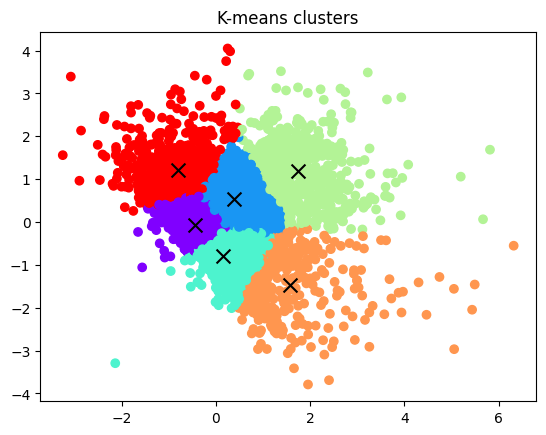

K-means silhouette score: 0.44990712
K-means homogeneity score: 0.09057989796009333


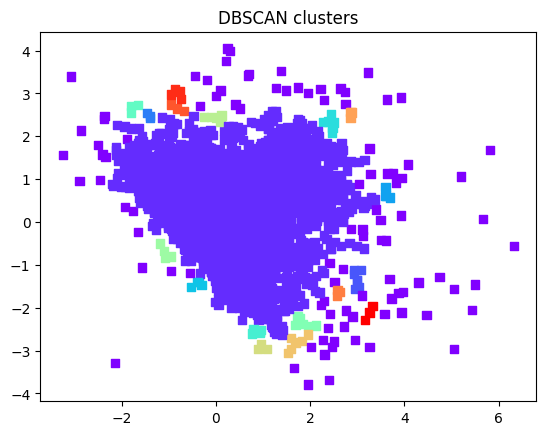

DBSCAN silhouette score: -0.02026077
DBSCAN homogeneity score: 0.005514260609479112


In [17]:
# Reduce the dimension of the data to 2 using PCA
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(vectors)

kmeans_labels = kmeans.fit_predict(X_reduced)

# Plot the k-means clusters
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_labels, cmap='rainbow', marker='o')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', color='black', s=100)
plt.title('K-means clusters')
plt.show()

# Calculate the silhouette score and the homogeneity score for k-means
kmeans_silhouette = silhouette_score(X_reduced, kmeans_labels)
kmeans_homogeneity = homogeneity_score(true_labels, kmeans_labels)
print('K-means silhouette score:', kmeans_silhouette)
print('K-means homogeneity score:', kmeans_homogeneity)

dbscan_labels = dbscan.fit_predict(X_reduced)

# Plot the DBSCAN clusters
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=dbscan_labels, cmap='rainbow', marker='s')
plt.title('DBSCAN clusters')
plt.show()

# Calculate the silhouette score and the homogeneity score for DBSCAN
dbscan_silhouette = silhouette_score(X_reduced, dbscan_labels)
dbscan_homogeneity = homogeneity_score(true_labels, dbscan_labels)
print('DBSCAN silhouette score:', dbscan_silhouette)
print('DBSCAN homogeneity score:', dbscan_homogeneity)

# Phase 3
## سوال 8
•  The silhouette coefficient is a measure of how well a data point fits in its assigned cluster, based on the distance to other clusters. It is calculated as the difference between the average distance to the points in the same cluster (cohesion) and the average distance to the points in the nearest cluster (separation), divided by the maximum of these two values. The silhouette coefficient ranges from -1 to 1, where 1 means the data point is very similar to its own cluster and very dissimilar to other clusters, and -1 means the opposite.

•  The homogeneity score is a measure of how well a cluster labeling matches the true class labels of the data points. It is calculated as the normalized conditional entropy of the true labels given the cluster labels. A cluster labeling is homogeneous if all of its clusters contain only data points from a single class. The homogeneity score ranges from 0 to 1, where 1 means the cluster labeling is perfectly homogeneous and 0 means it is completely random.

## سوال 10
**To improve the performance of k-means, you can try the following methods:**

* Choose a better initialization method for the cluster centroids, such as k-means++ or k-means||, which can reduce the chances of getting stuck in a local optimum.

*  Use a different distance measure, such as cosine similarity or Manhattan distance, which may be more suitable for your data than Euclidean distance.

*  Apply some preprocessing steps to your data, such as normalization, standardization, or dimensionality reduction, which can improve the clustering quality and speed.

*  Use some postprocessing steps to refine your clusters, such as splitting, merging, or reassigning outliers, which can improve the cluster cohesion and separation.

*  Use some validation methods to evaluate your clusters, such as silhouette score, Davies-Bouldin index, or Calinski-Harabasz index, which can help you choose the optimal number of clusters and compare different clustering results.

**To improve the performance of DBSCAN, you can try the following methods:**

*  Choose the optimal parameters for the radius (R) and the minimum number of points (M), which can affect the clustering quality and speed. You can use some methods such as k-distance graph, elbow method, or grid search to find the best values for your data.

*  Use a better index structure, such as k-d tree, R-tree, or ball tree, which can speed up the neighborhood query and reduce the computational complexity of DBSCAN.

*  Apply some preprocessing steps to your data, such as normalization, standardization, or dimensionality reduction, which can improve the clustering quality and speed.

*  Use some postprocessing steps to refine your clusters, such as splitting, merging, or reassigning outliers, which can improve the cluster cohesion and separation.

*  Use some validation methods to evaluate your clusters, such as silhouette score, Davies-Bouldin index, or Calinski-Harabasz index, which can help you compare different clustering results and identify the optimal density threshold.

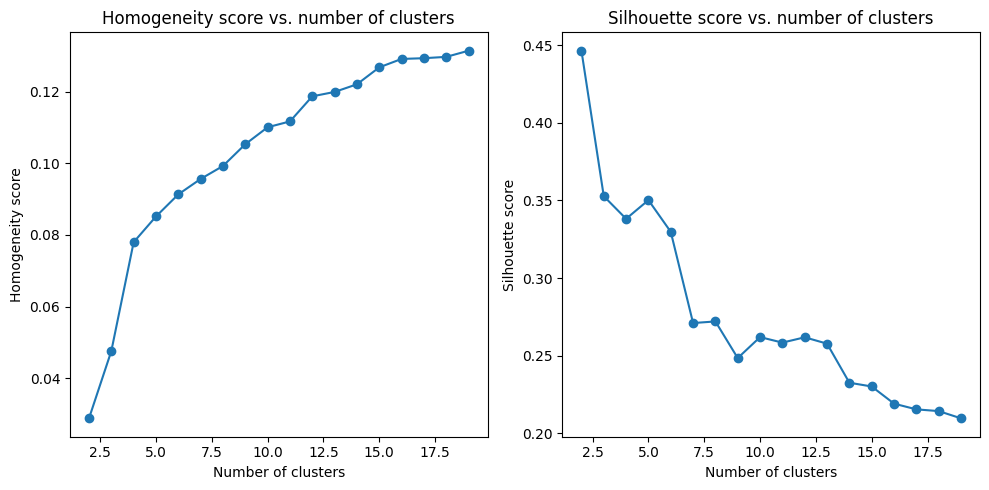

In [18]:
# Initialize the range of clusters
range_n_clusters = list(range(2, 20))

# Initialize the lists to store the scores
homogeneity_scores = []
silhouette_scores = []

best_kmeans = kmeans
max_score = 0

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans_labels = kmeans.fit_predict(vectors)

    # Calculate the homogeneity score and the silhouette score
    homogeneity = homogeneity_score(true_labels, kmeans_labels)
    silhouette = silhouette_score(vectors, kmeans_labels)

    # Append the scores to the lists
    homogeneity_scores.append(homogeneity)
    silhouette_scores.append(silhouette)

    if homogeneity + silhouette > max_score:
        best_kmeans = kmeans
        max_score = homogeneity + silhouette


# Plot the scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, homogeneity_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Homogeneity score')
plt.title('Homogeneity score vs. number of clusters')
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs. number of clusters')
plt.tight_layout()
plt.show()


In [20]:
# Define the range of eps values
eps_list = np.arange(start=0.1, stop=0.9, step=0.01)

# Define the range of min_samples values
min_sample_list = np.arange(start=2, stop=5, step=1)

best_dbscan = dbscan
max_score = 0

# Initialize the lists to store the scores
homogeneity_scores = []
silhouette_scores = []

# Loop over the range of parameters
for eps in eps_list:
    for min_samples in min_sample_list:
        # Perform DBSCAN clustering
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(vectors)

        # Calculate the homogeneity score and the silhouette score
        homogeneity = homogeneity_score(true_labels, dbscan_labels)
        silhouette = silhouette_score(vectors, dbscan_labels)

        # Append the scores to the lists
        homogeneity_scores.append(homogeneity)
        silhouette_scores.append(silhouette)

        if homogeneity + silhouette > max_score:
            best_dbscan = dbscan
            max_score = homogeneity + silhouette

# Plot the scores
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(eps_list, homogeneity_scores[:len(eps_list)], marker='o', color='red', label='min_samples=2')
plt.plot(eps_list, homogeneity_scores[len(eps_list):2*len(eps_list)], marker='s', color='green', label='min_samples=3')
plt.plot(eps_list, homogeneity_scores[2*len(eps_list):], marker='^', color='blue', label='min_samples=4')
plt.xlabel('eps')
plt.ylabel('Homogeneity score')
plt.title('Homogeneity score vs. eps')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(eps_list, silhouette_scores[:len(eps_list)], marker='o', color='red', label='min_samples=2')
plt.plot(eps_list, silhouette_scores[len(eps_list):2*len(eps_list)], marker='s', color='green', label='min_samples=3')
plt.plot(eps_list, silhouette_scores[2*len(eps_list):], marker='^', color='blue', label='min_samples=4')
plt.xlabel('eps')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs. eps')
plt.legend()
plt.subplot(2, 2, 3)
plt.scatter(vectors[:, 0], vectors[:, 1], c=true_labels, cmap='rainbow')
plt.title('True labels')
plt.subplot(2, 2, 4)
plt.scatter(vectors[:, 0], vectors[:, 1], c=dbscan_labels, cmap='rainbow')
plt.title('DBSCAN labels')
plt.tight_layout()
plt.show()

In [21]:
# efficient parameters result
kmeans_labels = best_kmeans.fit_predict(vectors)
dbscan_labels = best_dbscan.fit_predict(vectors)

print('K-means silhouette score:', silhouette_score(vectors, kmeans_labels))
print('K-means homogeneity score:', homogeneity_score(true_labels, kmeans_labels))

print('DBSCAN silhouette score:', silhouette_score(vectors, dbscan_labels))
print('DBSCAN homogeneity score:', homogeneity_score(true_labels, dbscan_labels))

K-means silhouette score: 0.4465145
K-means homogeneity score: 0.028754646875955955
DBSCAN silhouette score: 0.587156
DBSCAN homogeneity score: 0.0028757281795987843
